In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight
import numpy as np
import os
import warnings
import pydot as pyd
import seaborn as sns
import pandas as pd
from timeit import default_timer as timer
import matplotlib.pyplot as plt

warnings.simplefilter(action = 'ignore', category = FutureWarning)

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID";

# GPUid to use
os.environ["CUDA_VISIBLE_DEVICES"] = "0";

# Allow growth of GPU memory, otherwise it will always look like all the memory is being used
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
# Insert initial parameters
batch_size = 64
img_height, img_width = 224, 224
n_classes = 3

# Data augmentation
train_datagen = ImageDataGenerator(horizontal_flip = True, 
                                   vertical_flip = True,
                                   rotation_range = 45, 
                                   brightness_range = [0.5, 1.5],
                                   fill_mode = 'constant',
                                   samplewise_center = True,
                                   rescale = 1./255)

test_datagen = ImageDataGenerator(samplewise_center = True,
                                  rescale = 1./255)

train = train_datagen.flow_from_directory('/local/data1/elech646/Tumor_grade_classification/dataset224_t1_transversal/train', 
                                          classes = ['G2','G3','G4'], color_mode = 'rgb', 
                                          class_mode = 'categorical', 
                                          target_size = (img_height, img_width), 
                                          batch_size = batch_size, seed = 123)
validation = test_datagen.flow_from_directory('/local/data1/elech646/Tumor_grade_classification/dataset224_t1_transversal/val', 
                                              classes = ['G2','G3','G4'], color_mode = 'rgb',
                                              class_mode = 'categorical', 
                                              target_size = (img_height, img_width), 
                                              batch_size = batch_size, seed = 123)
test = test_datagen.flow_from_directory('/local/data1/elech646/Tumor_grade_classification/dataset224_t1_transversal/test', 
                                        classes = ['G2','G3','G4'], color_mode = 'rgb',
                                        shuffle = False, class_mode = 'categorical', 
                                        target_size = (img_height, img_width), 
                                        batch_size = batch_size)

Found 4830 images belonging to 3 classes.
Found 1274 images belonging to 3 classes.
Found 484 images belonging to 3 classes.


In [3]:
# Use class weights
class_weights = class_weight.compute_class_weight(class_weight = 'balanced', 
                                                  classes = np.unique(train.classes), 
                                                  y = train.classes)

# Convert to dictionary
class_weights = dict(enumerate(class_weights))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(64, 224, 224, 3) (64, 3)
-0.29266518


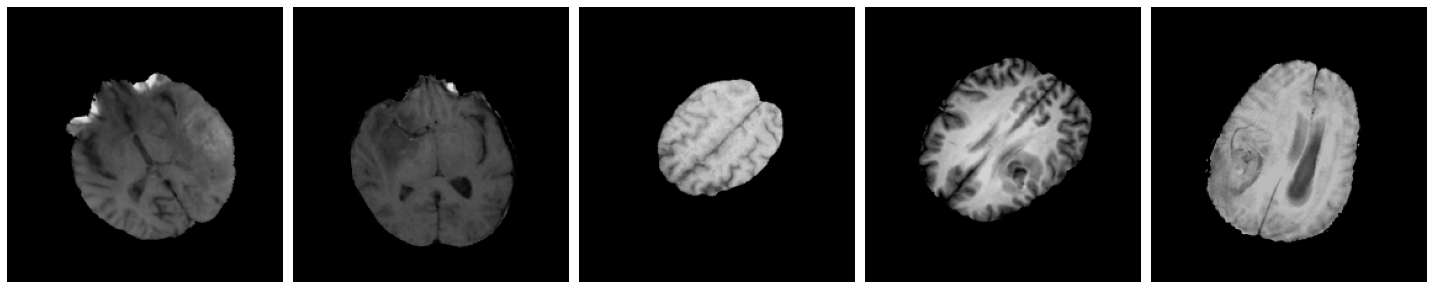

In [4]:
x_train, y_train = next(iter(train))
print(x_train.shape, y_train.shape)
print(x_train.min())

# Plot the images for fun
def plot_images(images):
    fig, axes = plt.subplots(1, 5, figsize = (20, 20))
    axes = axes.flatten()
    for img, ax in enumerate(axes):
        ax.imshow(images[img,:,:], cmap = 'gray')
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
plot_images(x_train[:1000])

In [23]:
# Load base model
resnet_50 = ResNet50(input_shape = (224, 224, 3), weights = 'imagenet', include_top = False)

freeze_until_layer = 100

# Freeze all layers before the `freeze_until_layer` layer
for layer in resnet_50.layers[:freeze_until_layer]:
    layer.trainable = False

x = resnet_50.output
x = Flatten()(x)
x = Dense(20, activation = 'relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(n_classes, activation = 'softmax')(x)

model = Model(inputs = resnet_50.input, outputs = predictions)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

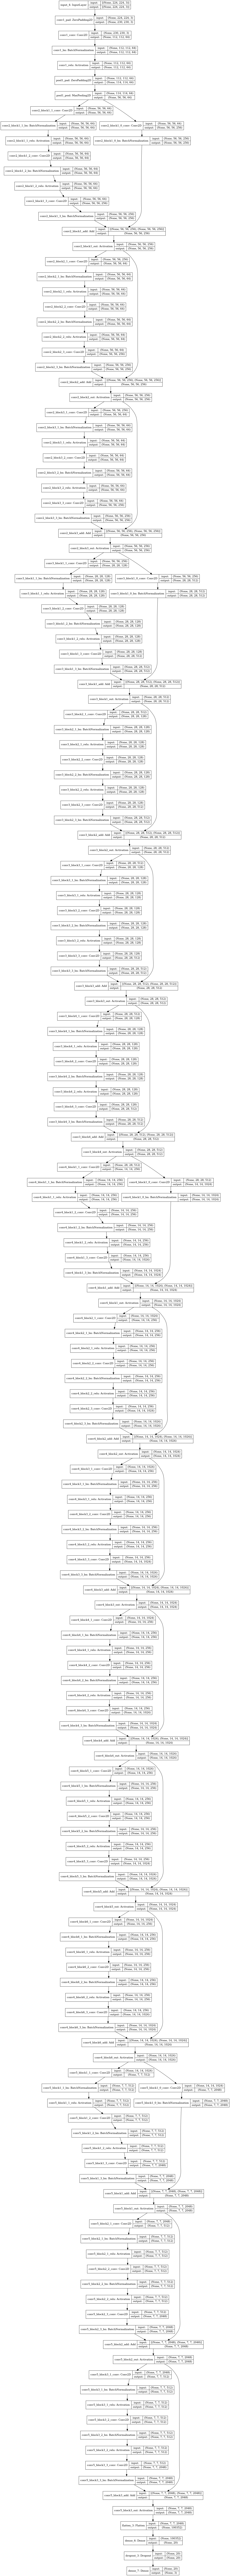

In [24]:
plot_model(model, to_file = 'resnet50_plot_t1_transversal.png', show_shapes = True, show_layer_names = True)

In [25]:
# Save best model
checkpoint_path = '/local/data1/elech646/code/train_logs/resnet50_transfer_t1_transversal.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                                monitor = 'val_accuracy',
                                                mode = 'max',
                                                verbose = 1,
                                                save_best_only = True)

# Save log for history
# append: True: append if file exists (useful for continuing training)//False: overwrite existing file
csv_logger = CSVLogger('/local/data1/elech646/code/train_logs/resnet50_transfer_history_t1_transversal.log', 
                       separator = ',', append = True)

# Reduce learning rate if val_accuracy is not improving
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.1,
                              patience = 5, min_lr = 0.000001)
es = EarlyStopping(monitor = 'val_accuracy', verbose = 1, 
                   patience = 15)

In [26]:
# Compile model
model.compile(Adam(lr = 1e-5),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

epochs = 35
start = timer()

history = model.fit(train, steps_per_epoch = len(train.labels) // batch_size, verbose = 1,
                    epochs = epochs, validation_data = validation,
                    validation_steps = len(validation.labels) // batch_size,
                    callbacks = [es, reduce_lr, checkpoint, csv_logger])

end = timer()
print("Training time: %.2f s\n" % (end - start))

Epoch 1/35
75/75 [==============================] - 40s 499ms/step - loss: 1.2268 - accuracy: 0.4301 - val_loss: 1.0644 - val_accuracy: 0.4852

Epoch 00001: val_accuracy improved from -inf to 0.48520, saving model to /local/data1/elech646/code/train_logs/resnet50_transfer_t1_transversal.h5
Epoch 2/35
75/75 [==============================] - 37s 488ms/step - loss: 1.0701 - accuracy: 0.4611 - val_loss: 1.0770 - val_accuracy: 0.4663

Epoch 00002: val_accuracy did not improve from 0.48520
Epoch 3/35
75/75 [==============================] - 37s 490ms/step - loss: 1.0598 - accuracy: 0.4609 - val_loss: 1.1347 - val_accuracy: 0.2393

Epoch 00003: val_accuracy did not improve from 0.48520
Epoch 4/35
75/75 [==============================] - 37s 492ms/step - loss: 1.0388 - accuracy: 0.4626 - val_loss: 1.0970 - val_accuracy: 0.4836

Epoch 00004: val_accuracy did not improve from 0.48520
Epoch 5/35
75/75 [==============================] - 37s 496ms/step - loss: 1.0380 - accuracy: 0.4637 - val_loss:

1st training:  

Data augmentation: brightness adjustments

Setup: `x = resnet_50.output
        x = Flatten()(x)
        x = Dense(20, activation = 'relu')(x)
        x = Dropout(0.3)(x)
        predictions = Dense(n_classes, activation = 'softmax')(x)`
       
batch size = 64 

number of epochs = 35

learning rate = 1e-5 with `ReduceLROnPlateau` + `EarlyStopping` (freezing 100 bottom layers)

training time: 444.77 s $\approx 8$ min

test accuracy: 0.4330

------------------------------------------------------------------------------------------------------------------

2nd training:

Data augmentation: horizontal + vertical flip, 45 degree rotation, `brightness_range = [0.5, 1.5]`, `fill_mode = 'constant'`

Setup: `x = resnet_50.output
        x = Flatten()(x)
        x = Dense(20, activation = 'relu')(x)
        x = Dropout(0.5)(x)
        predictions = Dense(n_classes, activation = 'softmax')(x)`
       
batch size = 64 

number of epochs = 35

learning rate = 1e-5 with `ReduceLROnPlateau` + `EarlyStopping`

training time: 1310.60 s $\approx 22$ min

test accuracy: 0.3683

In [27]:
score = model.evaluate(test, steps = len(test.labels) // batch_size, verbose = 0)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

Test loss: 1.3047
Test accuracy: 0.3683


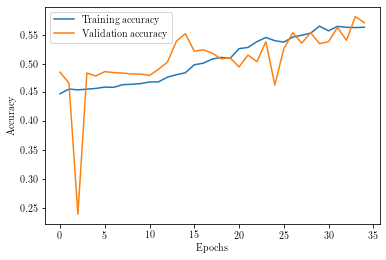

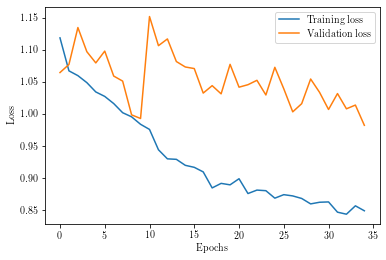

In [29]:
# Plot training + validation accuracy per epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
n_epochs = range(len(acc))

# for fancy LaTeX style plots
from matplotlib import rc
import matplotlib.pylab as plt

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex = True)

# Plot accuracy
plt.plot(n_epochs, acc, label = 'Training accuracy')
plt.plot(n_epochs, val_acc, label = 'Validation accuracy')
#plt.title('2nd training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc = 'best')
plt.savefig('ResNet50_2nd_training_t1_transversal_acc.png', dpi = 300)
plt.show()

# Plot loss
plt.plot(n_epochs, loss, label = 'Training loss')
plt.plot(n_epochs, val_loss, label = 'Validation loss')
#plt.title('2nd training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc = 'best')
plt.savefig('ResNet50_2nd_training_t1_transversal_loss.png', dpi = 300)
plt.show()

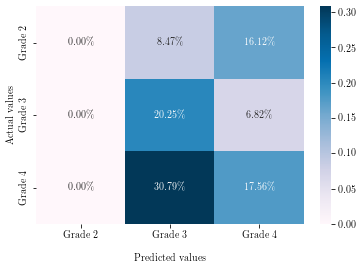

In [30]:
# Get true labels
y_true = test.classes

# Get rounded predictions
y_pred = np.argmax(model.predict(test), axis = 1) 

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)

#ax = sns.heatmap(cm, annot = True, cmap = 'Blues')
ax = sns.heatmap(cm / np.sum(cm), annot = True, fmt = '.2%', cmap = 'PuBu')
for t in ax.texts: 
    t.set_text(t.get_text().replace('%', '\%'))
ax.set_xlabel('\nPredicted values')
ax.set_ylabel('Actual values ');
# list must be in alphabetical order
ax.xaxis.set_ticklabels(['Grade 2','Grade 3', 'Grade 4'])
ax.yaxis.set_ticklabels(['Grade 2','Grade 3', 'Grade 4'])
plt.savefig('ResNet50-2nd_Training_CM_t1_transversal.png', dpi = 300)
plt.show()

In [31]:
# Print classification report
print(classification_report(y_true, y_pred))

# Save the classification report
clsf_report = pd.DataFrame(classification_report(y_true = y_true, y_pred = y_pred, output_dict = True)).transpose()
clsf_report.to_csv('Classification Report-ResNet50-2nd Training on t1 transversal.csv', index = True)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       119
           1       0.34      0.75      0.47       131
           2       0.43      0.36      0.40       234

    accuracy                           0.38       484
   macro avg       0.26      0.37      0.29       484
weighted avg       0.30      0.38      0.32       484



/local/data1/elech646/test/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/local/data1/elech646/test/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/local/data1/elech646/test/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/local/data1/elech6